In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from TFRHelper import *

# unlabeled data to use
* wider-face
* vggface

In [2]:
def is_img_valid(img):
    h, w, c = img.shape
    # resolution too small
    if max([h, w]) < 192:
#         print('invalid')
        return False
    if (w == 0) | (h == 0):
        return False
    # image dimension invalid
    if( np.round(w/h) > 1.0) | (np.round(h/w) > 1.0):
        return False
    return True

def get_face_bbox(img, bbox, padding):
    img_h, img_w, c = img.shape
    
    top, bot, left, right = bbox
    top, bot, left, right = [top * img_h, bot * img_h, left * img_w, right * img_w]
    h = bot - top
    w = right - left
    max_size = max(w, h)
    max_size = max_size * (1 + padding)
    
    def check_axis_validity(left, right, max_size, img_w):
        additional_h = 0
        w = right - left
        
        if w < max_size:
            additional_w = (max_size - w) / 2
            right = right + additional_w
            left = left - additional_w
            
        if right > img_w:
            additional_h = (1 - right) / 2 # negative number
            right = img_w
            
        if left < 0:
            additional_h = left / 2# negative number
            left = 0
        
        return left, right, additional_h
    
    iteration = 0
    cropping = True
    while cropping:
#         print(f'left: {left} \t right: {right}')
        left, right, additional_h = check_axis_validity(left, right, max_size, img_w)
#         print(f'new -> left: {left} \t right: {right} \t add_h: {additional_h}')
        top, bot = top - additional_h, bot + additional_h 
#         print(f'top {top} \t bot: {bot}')
        top, bot, additional_w = check_axis_validity(top, bot, max_size, img_h)
#         print(f'new -> top: {top} \t bot: {bot} \t add_w: {additional_w}')
        left, right = left - additional_w, right + additional_w
        iteration += 1
        
        if (int(additional_h) == 0) & (int(additional_w) == 0):
            cropping = False
        if iteration > 10:
            cropping = False

    return top, bot, left, right

# Wider Face

In [17]:
dataset = tfds.load('wider_face')
dataset.keys()

dict_keys(['test', 'train', 'validation'])

In [18]:
train = dataset['validation']
iterator = train.as_numpy_iterator()

In [19]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [24]:
write_path = '/home/gabe/data-archive/'

phases = ['train', 'validation']
for phase in phases:
    tfr_path = os.path.join(write_path, f'wider_face_{phase}.tfrecords')
    
    train = dataset[phase]
    iterator = train.as_numpy_iterator()
    
    counter = 0

    with tf.io.TFRecordWriter(tfr_path) as writer:
        for x in iterator:
            img = x['image']
            bboxes = x['faces']['bbox']
            w, h, c = img.shape

            for bbox in bboxes:
                top, left, bot, right = bbox
                bbox = [top, bot, left, right]

                face_bbox = get_face_bbox(img, bbox, 0.5)
                face = crop_image(img, face_bbox)
                valid = is_img_valid(face)

                if not valid:
                    continue

                face = cv2.resize(face, (240, 240))
                face_byte = tf.io.encode_jpeg(face, quality=100)

                feature = {
                    'image': _bytes_feature(face_byte)
                }

                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())

                counter += 1
                if counter % 5000 == 0:
                    print(counter)

5000


## View WiderFace DS

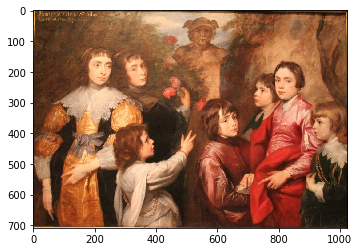

In [21]:
train = dataset['validation']
iterator = train.as_numpy_iterator()

x = iterator.next()

img = x['image']
bboxes = x['faces']['bbox']

plt.imshow(img)

(314.0000057592988, 439.99999605864286, 878.500004850328, 1004.499995149672)


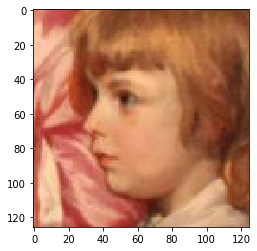

In [22]:
bbox = bboxes[0]

top, left, bot, right = bbox
bbox = [top, bot, left, right]

face_bbox = get_face_bbox(img, bbox, 0.5)
print(face_bbox)
face = crop_image(img, face_bbox)

plt.imshow(face)

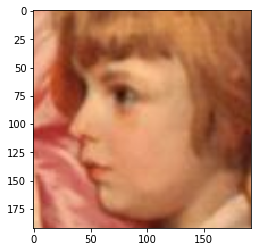

In [23]:
resized = cv2.resize(face, (240, 240))
centered = resized[24:24+192, 24:24+192]
plt.imshow(centered)

# VGGFace

In [3]:
from mtcnn import MTCNN
import os, sys
import cv2
sys.path.append('../')
from preprocess_dataset.TFRHelper import *
from utils.image_preprocessor import *
import concurrent.futures
import multiprocessing
import tensorflow as tf
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
# tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

face_detector = MTCNN()

0.9976561069488525 (251, 250, 3)


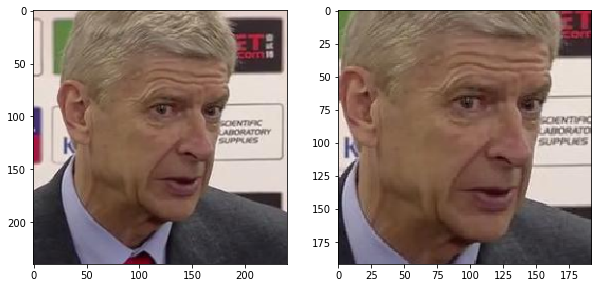

In [49]:
data_path = '/home/gabe/data-archive/vggface/test/'

subjects = os.listdir(data_path)

subject = np.random.choice(subjects)
fids = os.listdir(os.path.join(data_path, subject))
fid = np.random.choice(fids)
img_path = os.path.join(data_path, subject, fid)
img = cv2.imread(img_path)

results = face_detector.detect_faces(img)

h, w, c = img.shape
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

confidence = results[0]['confidence']

bbox = results[0]['box']
left, top, width, height= bbox
right = left + width
bottom = top + height

top, bottom, left, right = top/h, bottom/h, left/w, right/w
bbox = top, bottom, left, right
face_bbox = get_face_bbox(img, bbox, 0.50)
face = crop_image(rgb, face_bbox)
print(confidence, face.shape)
resized_face = cv2.resize(face, (240, 240))
cropped_face = resized_face[24:24+192, 24:24+192]

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(resized_face)
axes[1].imshow(cropped_face)

In [109]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def parse_one_image(img, results):

    if len(results) == 0:
        return None

    h, w, c = img.shape
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    confidence = results[0]['confidence']

    if confidence < 0.9:
        return None

    bbox = results[0]['box']
    left, top, width, height= bbox
    right = left + width
    bottom = top + height

    top, bottom, left, right = top/h, bottom/h, left/w, right/w
    bbox = top, bottom, left, right
    face_bbox = get_face_bbox(img, bbox, 0.35)
    face = crop_image(rgb, face_bbox)

    valid = is_img_valid(face)

    if not valid:
        return None

    face = cv2.resize(face, (240, 240))

    face_byte = tf.io.encode_jpeg(face, quality=100)

    feature = {
        'image': _bytes_feature(face_byte)
    }

    return feature

def parse_one_subject(subject, writer):
#     print(f'Doing {subject} - {i} /{len(subjects)}')
    start = time.time()
    temp_detector = MTCNN()

    fids = os.listdir(os.path.join(data_path, subject))

    for fid in fids:
        img_path = os.path.join(data_path, subject, fid)
        img = cv2.imread(img_path)
        results = temp_detector.detect_faces(img)
        
        feature = parse_one_image(img, results)

        if feature is not None:
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
    
    end = time.time()
    return end - start

In [30]:
data_path = '/home/gabe/data-archive/vggface/test/'
subjects = os.listdir(data_path)
write_path = '/home/gabe/data-archive/'
tfr_path = os.path.join(write_path, 'vggface_test.tfrecords')
counter = 0

subjects.sort()


with tf.io.TFRecordWriter(tfr_path) as writer:
    for i, subject in enumerate(subjects):
        print(f'Doing {subject} - {i} /{len(subjects)}')
        elapsed_time = parse_one_subject(subject, writer)
        print(f'\tCompleted : {subject}... took {int(elapsed_time)} seconds')
        
#         fids = os.listdir(os.path.join(data_path, subject))
#         for fid in fids:
#             img_path = os.path.join(data_path, subject, fid)
#             img = cv2.imread(img_path)
#             results = face_detector.detect_faces(img)

#             if len(results) == 0:
#                 continue

#             face = parse_one_image(img, results)
            
#             valid = is_img_valid(face)
            
#             if not valid:
#                 continue

#             face = cv2.resize(face, (240, 240))

#             counter += 1
#             face_byte = tf.io.encode_jpeg(face, quality=100)
            
#             feature = {
#                 'image': _bytes_feature(face_byte)
#             }

#             example = tf.train.Example(features=tf.train.Features(feature=feature))
#             writer.write(example.SerializeToString())

Doing n009232 - 0 /500
	Completed : n009232... took 7 seconds
Doing n000284 - 1 /500
	Completed : n000284... took 6 seconds
Doing n006458 - 2 /500


KeyboardInterrupt: 

#### Multithread
todo this doesn't work... I don't get it?

In [29]:
data_path = '/home/gabe/data-archive/vggface/test/'
write_path = '/home/gabe/data-archive/'
tfr_path = os.path.join(write_path, 'vggface_test.tfrecords')

max_thread_num = multiprocessing.cpu_count()
print(f'max_thread_num : {multiprocessing.cpu_count()}')

subjects = os.listdir(data_path)

with tf.io.TFRecordWriter(tfr_path) as writer:
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_thread_num) as executor:
        for i, subject in enumerate(subjects):
            print(f'Doing {subject} - {i} /{len(subjects)}')
            executor.submit(parse_one_subject, subject=subject, writer=writer)
#             print(f'\tCompleted : {subject}... took {int(elapsed_time)} seconds')

max_thread_num : 12
Doing n009232 - 0 /500
Doing n000284 - 1 /500
Doing n006458 - 2 /500
Doing n007121 - 3 /500
Doing n003917 - 4 /500
Doing n003134 - 5 /500
Doing n004338 - 6 /500
Doing n008773 - 7 /500
Doing n002743 - 8 /500
Doing n007571 - 9 /500
Doing n005326 - 10 /500
Doing n008047 - 11 /500
Doing n005973 - 12 /500
Doing n004387 - 13 /500
Doing n004563 - 14 /500
Doing n005473 - 15 /500
Doing n008615 - 16 /500
Doing n005122 - 17 /500
Doing n000928 - 18 /500
Doing n004064 - 19 /500
Doing n004801 - 20 /500
Doing n005226 - 21 /500
Doing n001059 - 22 /500
Doing n002878 - 23 /500
Doing n005730 - 24 /500
Doing n001838 - 25 /500
Doing n009225 - 26 /500
Doing n005709 - 27 /500
Doing n005636 - 28 /500
Doing n000129 - 29 /500
Doing n005301 - 30 /500
Doing n007650 - 31 /500
Doing n004394 - 32 /500
Doing n007919 - 33 /500
Doing n008484 - 34 /500
Doing n005799 - 35 /500
Doing n000394 - 36 /500
Doing n005693 - 37 /500
Doing n009291 - 38 /500
Doing n005764 - 39 /500
Doing n000040 - 40 /500
Doing 

KeyboardInterrupt: 